In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image  # Added missing import
from tqdm import tqdm

class RiceDiseaseDataset(Dataset):
    def __init__(self, csv_file, base_path, transform=None):
        self.data = pd.read_csv(csv_file)
        self.base_path = base_path
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        
        # Print dataset information
        print(f"Number of classes: {len(self.label_mapping)}")
        print("Label mapping:", self.label_mapping)
        
        # Verify and store valid image paths
        self.valid_data = []  # Changed to store valid entries
        for _, row in self.data.iterrows():
            img_name = row['image_id']
            label = row['label']
            
            # Check in label subdirectory
            potential_path = os.path.join(self.base_path, label, img_name)
            if os.path.exists(potential_path):
                self.valid_data.append({
                    'image_path': potential_path,
                    'label': label
                })
        
        print(f"Found {len(self.valid_data)} valid images")

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        item = self.valid_data[idx]
        img = Image.open(item['image_path']).convert('RGB')
        label = self.label_mapping[item['label']]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

class CustomRiceNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomRiceNet, self).__init__()
        
        # Feature extractors
        self.resnet_features = models.resnet18(weights='IMAGENET1K_V1')  # Updated pretrained parameter
        resnet_out = self.resnet_features.fc.in_features
        self.resnet_features.fc = nn.Identity()
        
        self.densenet_features = models.densenet121(weights='IMAGENET1K_V1')  # Updated pretrained parameter
        densenet_out = self.densenet_features.classifier.in_features
        self.densenet_features.classifier = nn.Identity()
        
        combined_features = resnet_out + densenet_out
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Linear(512, 1),  # Changed to output single attention weight
            nn.Sigmoid()
        )
        
        # Feature fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(combined_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Final classification layer
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # Extract features from both networks
        resnet_out = self.resnet_features(x)
        densenet_out = self.densenet_features(x)
        
        # Concatenate features
        combined_features = torch.cat((resnet_out, densenet_out), dim=1)
        
        # Apply attention
        attention_weights = self.attention(combined_features)
        weighted_features = combined_features * attention_weights
        
        # Fuse features
        fused_features = self.fusion(weighted_features)
        
        # Final classification
        output = self.classifier(fused_features)
        
        return output

class CustomRiceLoss(nn.Module):
    def __init__(self):
        super(CustomRiceLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, outputs, targets):
        return self.criterion(outputs, targets)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    best_val_loss = float('inf')
    training_history = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, targets in tqdm(train_loader, desc='Training'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validation'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, 'best_custom_rice_model.pth')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Store results
        training_history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    return training_history

def main():
    # Set random seed
    torch.manual_seed(42)
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    csv_file = '/kaggle/input/paddydoctor/train.csv'
    base_path = '/kaggle/input/paddydoctor/train_images'
    
    full_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=None)
    
    # Split indices
    train_indices, val_indices = train_test_split(
        range(len(full_dataset)),
        test_size=0.2,
        random_state=42
    )

    # Create train and validation datasets
    train_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=train_transforms)
    val_dataset = RiceDiseaseDataset(csv_file=csv_file, base_path=base_path, transform=val_transforms)

    # Create subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # Create dataloaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model
    model = CustomRiceNet(num_classes=len(full_dataset.label_mapping))
    model = model.to(device)

    # Initialize loss and optimizer
    criterion = CustomRiceLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )

    # Train the model
    training_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=50
    )

    # Save training history
    pd.DataFrame(training_history).to_csv('training_history.csv', index=False)

if __name__ == '__main__':
    main()

Using device: cuda
Number of classes: 10
Label mapping: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
Found 10407 valid images
Number of classes: 10
Label mapping: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
Found 10407 valid images
Number of classes: 10
Label mapping: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
Found 10407 valid images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s] 
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.14it/s]


Train Loss: 1.9462 | Train Acc: 31.17%
Val Loss: 1.8264 | Val Acc: 37.27%

Epoch 2/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.08it/s]


Train Loss: 1.6858 | Train Acc: 41.90%
Val Loss: 1.4592 | Val Acc: 48.08%

Epoch 3/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.22it/s]


Train Loss: 1.5281 | Train Acc: 47.81%
Val Loss: 1.3848 | Val Acc: 53.12%

Epoch 4/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.08it/s]


Train Loss: 1.4078 | Train Acc: 52.43%
Val Loss: 1.3422 | Val Acc: 54.76%

Epoch 5/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]


Train Loss: 1.2562 | Train Acc: 58.23%
Val Loss: 1.2335 | Val Acc: 60.04%

Epoch 6/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.17it/s]


Train Loss: 1.1841 | Train Acc: 60.35%
Val Loss: 0.9308 | Val Acc: 67.44%

Epoch 7/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


Train Loss: 1.0945 | Train Acc: 63.71%
Val Loss: 0.8492 | Val Acc: 71.47%

Epoch 8/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]


Train Loss: 1.0050 | Train Acc: 66.85%
Val Loss: 0.8188 | Val Acc: 72.77%

Epoch 9/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.12it/s]


Train Loss: 0.9642 | Train Acc: 68.76%
Val Loss: 0.7290 | Val Acc: 75.12%

Epoch 10/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]


Train Loss: 0.9036 | Train Acc: 70.31%
Val Loss: 0.7336 | Val Acc: 75.36%

Epoch 11/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]


Train Loss: 0.8573 | Train Acc: 72.02%
Val Loss: 0.6750 | Val Acc: 77.47%

Epoch 12/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]


Train Loss: 0.8271 | Train Acc: 73.12%
Val Loss: 0.6572 | Val Acc: 77.81%

Epoch 13/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]


Train Loss: 0.7929 | Train Acc: 74.31%
Val Loss: 0.5356 | Val Acc: 82.90%

Epoch 14/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.63it/s]


Train Loss: 0.7410 | Train Acc: 75.76%
Val Loss: 0.6954 | Val Acc: 77.76%

Epoch 15/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.21it/s]


Train Loss: 0.6965 | Train Acc: 76.91%
Val Loss: 0.5051 | Val Acc: 83.91%

Epoch 16/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]


Train Loss: 0.6567 | Train Acc: 78.71%
Val Loss: 0.5470 | Val Acc: 81.41%

Epoch 17/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.13it/s]


Train Loss: 0.6398 | Train Acc: 79.35%
Val Loss: 0.5375 | Val Acc: 81.36%

Epoch 18/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]


Train Loss: 0.5941 | Train Acc: 80.85%
Val Loss: 0.4462 | Val Acc: 84.58%

Epoch 19/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Train Loss: 0.5908 | Train Acc: 80.92%
Val Loss: 0.4472 | Val Acc: 84.05%

Epoch 20/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]


Train Loss: 0.5653 | Train Acc: 81.65%
Val Loss: 0.4582 | Val Acc: 84.92%

Epoch 21/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]


Train Loss: 0.5494 | Train Acc: 82.05%
Val Loss: 0.4083 | Val Acc: 86.89%

Epoch 22/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]


Train Loss: 0.5216 | Train Acc: 83.14%
Val Loss: 0.4070 | Val Acc: 86.84%

Epoch 23/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]


Train Loss: 0.5114 | Train Acc: 83.62%
Val Loss: 0.5165 | Val Acc: 81.22%

Epoch 24/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.18it/s]


Train Loss: 0.4987 | Train Acc: 84.23%
Val Loss: 0.5482 | Val Acc: 83.62%

Epoch 25/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.65it/s]


Train Loss: 0.4835 | Train Acc: 84.44%
Val Loss: 0.3610 | Val Acc: 88.76%

Epoch 26/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.68it/s]


Train Loss: 0.4571 | Train Acc: 85.00%
Val Loss: 0.3522 | Val Acc: 88.23%

Epoch 27/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.30it/s]


Train Loss: 0.4346 | Train Acc: 86.23%
Val Loss: 0.3671 | Val Acc: 88.04%

Epoch 28/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.65it/s]


Train Loss: 0.4406 | Train Acc: 86.03%
Val Loss: 0.3205 | Val Acc: 90.39%

Epoch 29/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


Train Loss: 0.4133 | Train Acc: 86.83%
Val Loss: 0.3552 | Val Acc: 88.23%

Epoch 30/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]


Train Loss: 0.4126 | Train Acc: 87.03%
Val Loss: 0.3930 | Val Acc: 87.66%

Epoch 31/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Train Loss: 0.4083 | Train Acc: 87.23%
Val Loss: 0.3748 | Val Acc: 87.70%

Epoch 32/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]


Train Loss: 0.3836 | Train Acc: 87.98%
Val Loss: 0.3039 | Val Acc: 90.63%

Epoch 33/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.50it/s]


Train Loss: 0.3582 | Train Acc: 88.80%
Val Loss: 0.3713 | Val Acc: 88.14%

Epoch 34/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Train Loss: 0.3795 | Train Acc: 88.20%
Val Loss: 0.3187 | Val Acc: 90.59%

Epoch 35/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.62it/s]


Train Loss: 0.3581 | Train Acc: 88.71%
Val Loss: 0.2772 | Val Acc: 90.83%

Epoch 36/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Train Loss: 0.3460 | Train Acc: 89.32%
Val Loss: 0.2549 | Val Acc: 92.07%

Epoch 37/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Train Loss: 0.3258 | Train Acc: 89.47%
Val Loss: 0.2840 | Val Acc: 91.16%

Epoch 38/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.07it/s]


Train Loss: 0.3175 | Train Acc: 90.04%
Val Loss: 0.3127 | Val Acc: 90.06%

Epoch 39/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.48it/s]


Train Loss: 0.3293 | Train Acc: 89.71%
Val Loss: 0.2428 | Val Acc: 92.41%

Epoch 40/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]


Train Loss: 0.3030 | Train Acc: 90.21%
Val Loss: 0.2475 | Val Acc: 91.83%

Epoch 41/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.50it/s]


Train Loss: 0.2872 | Train Acc: 90.82%
Val Loss: 0.2958 | Val Acc: 91.16%

Epoch 42/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]


Train Loss: 0.2936 | Train Acc: 90.61%
Val Loss: 0.2508 | Val Acc: 92.22%

Epoch 43/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Train Loss: 0.2882 | Train Acc: 90.88%
Val Loss: 0.2990 | Val Acc: 91.02%

Epoch 44/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.43it/s]


Train Loss: 0.1925 | Train Acc: 94.21%
Val Loss: 0.1920 | Val Acc: 94.48%

Epoch 45/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.65it/s]


Train Loss: 0.1488 | Train Acc: 95.42%
Val Loss: 0.1824 | Val Acc: 94.81%

Epoch 46/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


Train Loss: 0.1378 | Train Acc: 95.78%
Val Loss: 0.1790 | Val Acc: 95.20%

Epoch 47/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.45it/s]


Train Loss: 0.1389 | Train Acc: 95.70%
Val Loss: 0.1883 | Val Acc: 94.91%

Epoch 48/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.42it/s]


Train Loss: 0.1264 | Train Acc: 96.12%
Val Loss: 0.1857 | Val Acc: 94.72%

Epoch 49/50


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.66it/s]


Train Loss: 0.1212 | Train Acc: 96.23%
Val Loss: 0.1711 | Val Acc: 95.49%

Epoch 50/50


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.50it/s]


Train Loss: 0.1125 | Train Acc: 96.50%
Val Loss: 0.1833 | Val Acc: 95.24%


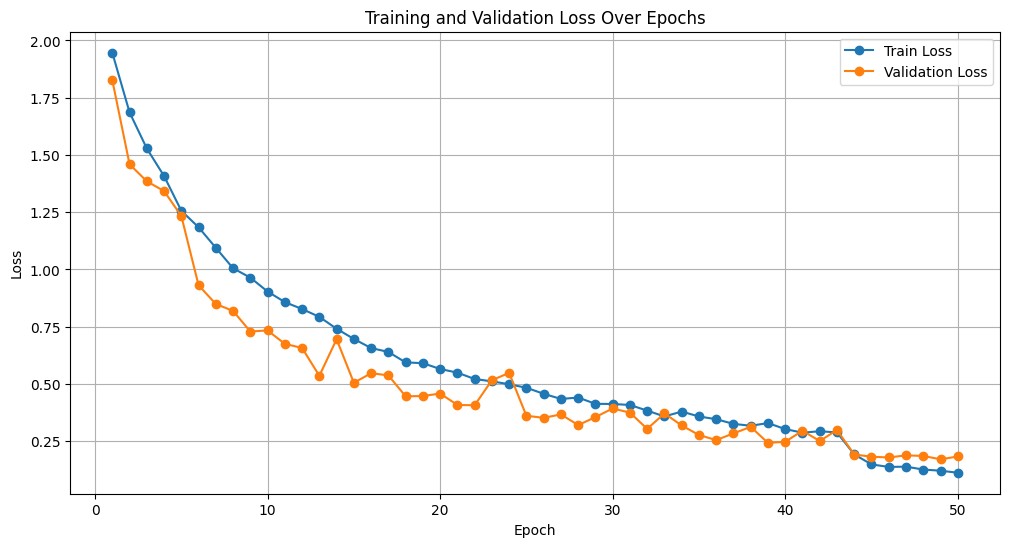

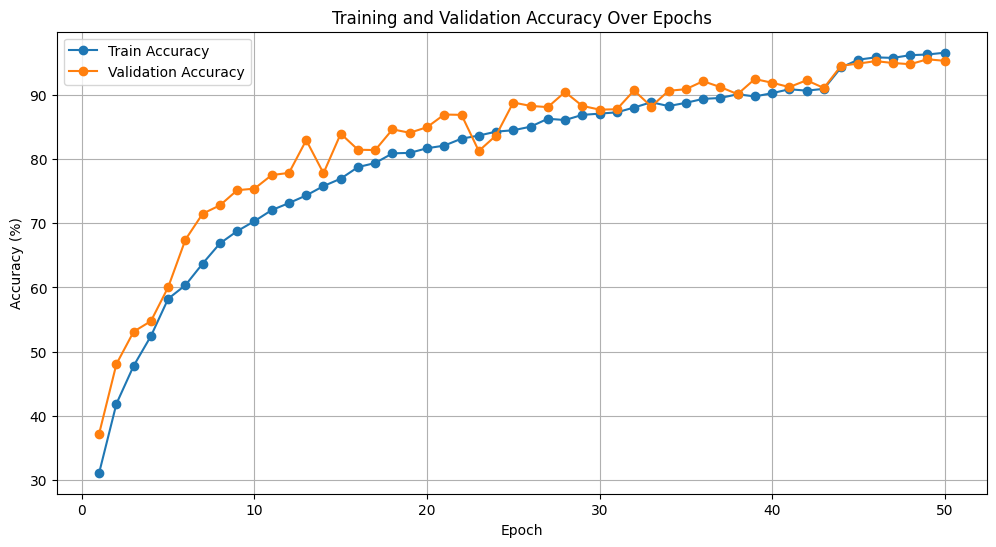

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training history
training_history = pd.read_csv('training_history.csv')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(training_history['epoch'], training_history['train_loss'], label='Train Loss', marker='o')
plt.plot(training_history['epoch'], training_history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_history['epoch'], training_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(training_history['epoch'], training_history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()
